In [ ]:
!pip install pycaret

In [ ]:
!pip install markupsafe==2.0.1
import jinja2

In [2]:

from pycaret.classification import *


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# # Import Required Library

import pandas as pd
from google.colab import drive 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
drive.mount('/content/gdrive')

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/path_to your_train_data_set')
train_data=df[['document','label']]
train_data.head()


,document,label
0,Stephen Sondheim's SWEENEY TODD: THE DEMON BAR...,positive
1,The only good thing about this movie is that I...,negative
2,I'm afraid this one is pretty dreadful despite...,negative
3,The acting was terrible the cheesy fake CHEAP ...,negative
4,The DVD was a joke the audio for the first few...,negative


# Cleaning the data set

In [5]:
'''
Data Cleaning
Data cleaning is one of the early steps in machine learning workflow that generally comes
after gathering data. Here we clean the data as a part of text-preprocessing  in such a 
way that it can be made ready to fed to the model to carry out the further processes.

'''


# Cleaning Training Data set
lem = WordNetLemmatizer()

# start with training data
import re
train_data_clean = (
    train_data
    # convert text to lowercase for consistency through out the corpus
    .assign(clean_document= lambda x:[text.lower() for text in x.document])
    # Remove the "<br/>"
     .assign(clean_document= lambda x: [re.sub(r"^<br />$"," ",doc) for doc in x.clean_document])
     # Remove the "digits "
     .assign(clean_document= lambda x: [re.sub(r'[~^0-9]',"",doc) for doc in x.clean_document])
     # Remove the "br"
     .assign(clean_document= lambda x: [re.sub(r"br"," ",doc) for doc in x.clean_document])
      #Remove “\n” which represents new line  
     .assign(clean_document= lambda x: [re.sub(r"\n","",doc) for doc in x.clean_document] )
      #Remove mentions i.e. any alphanumeric starting with “@”
     .assign(clean_document= lambda x: [re.sub("\@","",text) for text in x.clean_document])
      # Remove punctuation
     .assign(clean_document= lambda x: [re.sub("[^\w\s]","",text) for text in x.clean_document])
      # Tokenize
     .assign(word_token= lambda x: [nltk.word_tokenize(text) for text in x.clean_document] )
     # Remove stop words
     .assign(word_token= lambda x: [list(set(list_of_words).difference(stop_words)) for list_of_words in x.word_token])
      # Lemmatising the words
     .assign(word_token= lambda x: [[lem.lemmatize(a_word) for a_word in list_of_words] for list_of_words in x.word_token])
      # join the tokenized word 
     .assign(document_to_sklearn= lambda x: [" ".join(map(str,list_of_words)) for list_of_words in x.word_token ])  
)
train_data_clean.head()


,document,label,clean_document,word_token,document_to_sklearn
0,Stephen Sondheim's SWEENEY TODD: THE DEMON BAR...,positive,stephen sondheims sweeney todd the demon barbe...,"[opened, whose, play, shave, patti, theatre, s...",opened whose play shave patti theatre shaved d...
1,The only good thing about this movie is that I...,negative,the only good thing about this movie is that i...,"[ever, sucked, like, another, list, movie, fac...",ever sucked like another list movie face write...
2,I'm afraid this one is pretty dreadful despite...,negative,im afraid this one is pretty dreadful despite ...,"[device, soo, muddled, child, writerdirector, ...",device soo muddled child writerdirector insert...
3,The acting was terrible the cheesy fake CHEAP ...,negative,the acting was terrible the cheesy fake cheap ...,"[ever, like, making, movie, creature, effect, ...",ever like making movie creature effect became ...
4,The DVD was a joke the audio for the first few...,negative,the dvd was a joke the audio for the first few...,"[ever, mark, buster, segal, get, another, dvd,...",ever mark buster segal get another dvd movie c...


# Exploratory Data Analysis

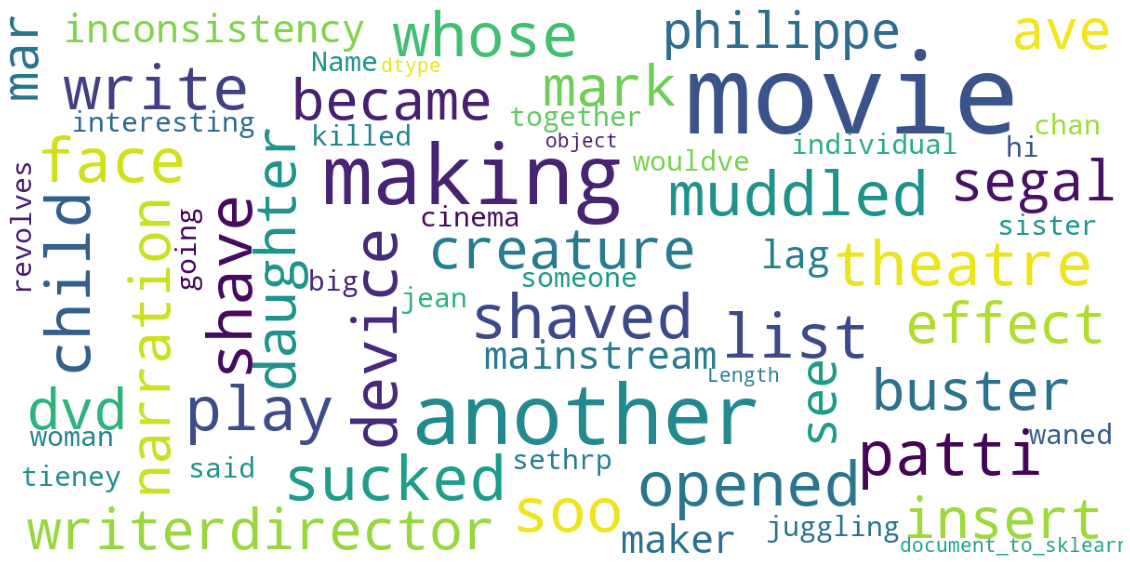

In [6]:
'''
As a part of exploratory data analysis we are using word cloud to see the most
frequent word in the corpus
'''

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=7000,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train_data_clean['document_to_sklearn'])


In [7]:
'''
Lets see the ratio of the positive and Negative sentiments in the givem dataset.
'''
train_data_clean["label"].value_counts()

negative    1012
positive     988
Name: label, dtype: int64

Text(0.5, 1.0, 'Sentiment Distributions)')

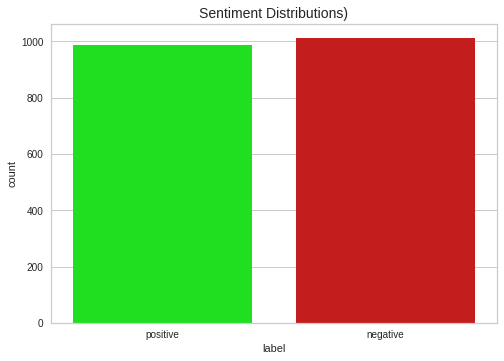

In [8]:
'''
Visualize the distribution of the sentiments
'''
import matplotlib.pyplot as plt
import seaborn as sns

colors = ["#00FF00", "#DF0101"]
sns.countplot('label', data=train_data_clean, palette=colors)
plt.title('Sentiment Distributions)', fontsize=14)

# Feature Engineering


In [9]:
'''
Since the label are given as positive and negative
lets change then to 0 and 1 so that it would be easier for machine to learn.
1 if the document has positive sentiment
0 if the document has negative sentiment 
'''
train_data_clean['label'] = train_data_clean['label'].apply(lambda x: 1 if x == "positive" else "0")

train_data_clean.head()


,document,label,clean_document,word_token,document_to_sklearn
0,Stephen Sondheim's SWEENEY TODD: THE DEMON BAR...,1,stephen sondheims sweeney todd the demon barbe...,"[opened, whose, play, shave, patti, theatre, s...",opened whose play shave patti theatre shaved d...
1,The only good thing about this movie is that I...,0,the only good thing about this movie is that i...,"[ever, sucked, like, another, list, movie, fac...",ever sucked like another list movie face write...
2,I'm afraid this one is pretty dreadful despite...,0,im afraid this one is pretty dreadful despite ...,"[device, soo, muddled, child, writerdirector, ...",device soo muddled child writerdirector insert...
3,The acting was terrible the cheesy fake CHEAP ...,0,the acting was terrible the cheesy fake cheap ...,"[ever, like, making, movie, creature, effect, ...",ever like making movie creature effect became ...
4,The DVD was a joke the audio for the first few...,0,the dvd was a joke the audio for the first few...,"[ever, mark, buster, segal, get, another, dvd,...",ever mark buster segal get another dvd movie c...


In [10]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

'''
Feature extraction can be understood as the mechanism to transform arbitary data such as 
text and images to numerical features which are usable for machine learning.

Now we neeed to extract the features from the dataset we have just cleaned and explored
For feature extraction from text data we can use various methods. 

'''

# vectorizer = CountVectorizer(max_features = 1000)
vectorizer = TfidfVectorizer(max_features = 1000)
X = vectorizer.fit_transform([i for i in train_data_clean['document_to_sklearn']])
# Use the same vectorizer to extract the features from test data(later) as well
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn['label'] = train_data_clean['label']
y = train_data_clean['label']
df_bow_sklearn.columns


# Here we have extracted 1000 features from the data



Index(['ability', 'able', 'absolutely', 'accent', 'across', 'act', 'acted',
       'acting', 'action', 'actor',
       ...
       'year', 'yes', 'yet', 'york', 'youll', 'young', 'younger', 'youre',
       'youve', 'label'],
      dtype='object', length=1001)

In [11]:
df_bow_sklearn

,ability,able,absolutely,accent,across,act,acted,acting,action,actor,actress,actual,actually,add,added,admit,adult,adventure,age,ago,agree,air,alien,alive,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,animal,animation,annoying,another,answer,anyone,anything,anyway,apart,apparently,appear,appearance,appeared,appears,area,arent,around,art,aside,ask,aspect,attack,attempt,attention,audience,average,avoid,award,away,awful,baby,back,background,bad,badly,barely,based,basically,battle,beat,beautiful,beauty,became,become,becomes,begin,beginning,behind,belief,believable,believe,best,better,beyond,big,biggest,bill,bit,bizarre,black,blood,body,book,bored,boring,bother,bottom,bought,box,boy,budget,build,building,bunch,business,buy,call,called,came,camera,cant,car,care,career,cartoon,case,cast,casting,caught,cause,century,certain,certainly,chance,change,changed,channel,character,chase,cheap,check,cheesy,chemistry,child,choice,cinema,cinematic,cinematography,city,class,classic,clear,clearly,clever,close,cold,college,come,comedy,comic,coming,comment,common,company,compare,compared,complete,completely,concept,conclusion,consider,considering,convincing,cool,cop,copy,costume,could,couldnt,country,couple,course,cover,crap,crazy,create,created,creature,credit,creepy,crew,crime,cry,culture,cut,cute,dance,dark,date,daughter,david,day,dead,deal,death,decade,decent,decide,decided,deep,definitely,depth,deserves,despite,detail,detective,development,dialog,dialogue,didnt,die,died,different,difficult,directed,directing,direction,director,disappointed,doctor,documentary,doesnt,dog,done,dont,door,doubt,dr,drama,dramatic,dream,drug,due,dull,dumb,dvd,eak,earlier,early,earth,easily,easy,editing,effect,...,series,serious,seriously,set,setting,several,sex,sexual,sexy,shame,shes,shooting,short,shot,show,showed,showing,shown,side,silly,similar,simple,simply,since,singing,single,sister,sit,situation,slightly,slow,small,social,society,soldier,solid,somehow,someone,something,sometimes,somewhat,son,song,soon,sorry,sort,sound,soundtrack,space,speak,special,spent,spirit,spoiler,spot,stage,stand,standard,star,starring,start,started,state,stay,still,stop,story,storyline,straight,strange,street,strong,struggle,student,studio,stuff,stupid,style,subject,success,successful,suddenly,superb,support,supporting,supposed,sure,surprise,surprised,surprisingly,suspect,suspense,sweet,take,taken,taking,tale,talent,talented,talk,talking,taste,team,tear,teen,teenager,television,tell,telling,ten,term,terrible,th,thanks,thats,theater,theme,there,theyre,thing,think,thinking,third,though,thought,three,thriller,throughout,throw,thrown,time,title,today,together,told,tom,took,top,total,totally,touch,towards,town,track,trailer,tried,trouble,true,truly,truth,try,trying,turn,turned,tv,twist,two,type,typical,ultimately,understand,unfortunately,unique,unless,unlike,upon,us,use,used,using,usual,usually,value,various,version,victim,video,view,viewer,viewing,villain,violence,voice,wait,waiting,walk,walking,want,wanted,war,wasnt,waste,wasted,watch,watched,watching,water,way,weak,wear,week,weird,well,went,werent,western,whatever,whats,whether,white,who,whole,whose,wife,william,win,wish,within,without,woman,wonder,wonderful,wont,wood,word,work,worked,working,world,worse,worst,worth,would,wouldnt,write,writer,writing,written,wrong,wrote,year,yes,yet,york,youll,young,younger,youre,youve,label
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.08902,0.0,0.053369,0.077255,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.114937,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090914,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.10623,0.098058,0.0,0.0,

# Modeling With PyCaret.

In [12]:
'''
One of the easiest way of modeling the data is with pycaret it easy to use and provides performance
of all the algorithms with single line of code.
'''
s = setup(data = df_bow_sklearn, target='label',
          numeric_features=vectorizer.get_feature_names(),
          session_id=123,verbose=False,silent=True)

In [13]:
# sort the classifaction algorithms by accuracy.
com  = compare_models(sort='Accuracy') 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8270,0.9042,0.8547,0.8115,0.8322,0.6539,0.6555,0.651
et,Extra Trees Classifier,0.8092,0.8871,0.7864,0.8269,0.8053,0.6184,0.6203,1.009
ridge,Ridge Classifier,0.8070,0.0000,0.8206,0.8005,0.8100,0.6140,0.6150,0.137
rf,Random Forest Classifier,0.7963,0.8781,0.7821,0.8062,0.7936,0.5926,0.5934,1.318
lightgbm,Light Gradient Boosting Machine,0.7906,0.8763,0.8163,0.7782,0.7964,0.5811,0.5825,1.106
nb,Naive Bayes,0.7763,0.8354,0.7536,0.7929,0.7713,0.5526,0.5550,0.093
svm,SVM - Linear Kernel,0.7756,0.0000,0.7708,0.7804,0.7742,0.5513,0.5531,0.181
gbc,Gradient Boosting Classifier,0.7620,0.8542,0.8192,0.7373,0.7755,0.5238,0.5283,3.221
ada,Ada Boost Classifier,0.7548,0.8363,0.7821,0.7425,0.7609,0.5096,0.5122,0.756
knn,K Neighbors Classifier,0.6734,0.7398,0.6396,0.6894,0.6622,0.3467,0.3489,0.975


From above table we can see that  Light Gradient Boosting Machine is performing well than other algorithms so we will be using the same  to predict the sentiment on the test data


In [14]:
# Lets evaluate the best model according to accuracy.
evaluate_model(com)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
'''
We can navigate to the different tab provided by pycaret evaluation_model method and analyse the
visualizations provided.
'''

In [15]:

X=df_bow_sklearn.iloc[:,:-1]
# predicting on the train data 
predictions = predict_model(com, data=X)
predictions['Label']

0       1
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    0
1998    1
1999    0
Name: Label, Length: 2000, dtype: int64

# Modeling with Sklearn

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_data_clean['document_to_sklearn'],train_data_clean['label'],random_state=12,test_size=0.2)
y_train = y_train.astype(int)
y_train

1027    1
1538    1
1145    0
1922    0
1631    1
       ..
1265    1
1277    0
1414    1
1691    1
1867    1
Name: label, Length: 1600, dtype: int64

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(x_train)
X_train

<1600x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 87762 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

y_train =y_train.astype('int')
svm = svm.SVC(kernel = 'linear', C=1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_train)

classification_report_= classification_report(y_train, y_pred)
print("classification_report_\n",classification_report_)
print('\n Accuracy: ', accuracy_score(y_train, y_pred))


classification_report_
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       811
           1       0.94      0.94      0.94       789

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600


 Accuracy:  0.93875


In [19]:
'''
In order to make the workflow much readable and understandable lets use pipeline. 
Furthermore pipeline helps in making the work reproducible.
'''

'\nIn order to make the workflow much readable and understandable lets use pipeline. \nFurthermore pipeline helps in making the work reproducible.\n'

# Using Pipeline


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# Make the pipeline.
review_clf = Pipeline([
   ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', svm.SVC()),
 ])


In [21]:
# Train using the pipeline
review_clf.fit(x_train,y_train)
y_pred = review_clf.predict(x_train)
# Lets see how it does on training data which it is trained upon
classification_report_= classification_report(y_train, y_pred)
print("classification_report_\n",classification_report_)
print('\n Accuracy: ', accuracy_score(y_train, y_pred))


classification_report_
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       811
           1       1.00      1.00      1.00       789

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


 Accuracy:  1.0


In [22]:
from sklearn.metrics import accuracy_score, classification_report
# Lets see how it does on training data which it is trained upon
classification_report_= classification_report(y_train, y_pred)
print("classification_report_\n",classification_report_)
print('\n Accuracy: ', accuracy_score(y_train, y_pred))


classification_report_
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       811
           1       1.00      1.00      1.00       789

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


 Accuracy:  1.0


In [23]:
y_test=y_test.astype(int)
y_test.shape

(400,)

In [24]:
'''
It seems we have built our pipeline well. Lets try it out on our validation data set.
'''

y_val_test =review_clf.predict(x_test)
classification_report_= classification_report(y_test, y_val_test)
print("classification_report_\n",classification_report_)
print('\n Accuracy: ', accuracy_score(y_test, y_val_test))




classification_report_
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       201
           1       0.86      0.83      0.85       199

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400


 Accuracy:  0.85


In [25]:
from sklearn.metrics import accuracy_score, classification_report

y=df_bow_sklearn.iloc[::,-1]
y =y.astype(int)
y_pred =predictions['Label']
classification_report_= classification_report(y, y_pred)
print("classification_report_\n",classification_report_)
print('\n Accuracy: ', accuracy_score(y, y_pred))

classification_report_
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1012
           1       0.90      0.90      0.90       988

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


 Accuracy:  0.9025


# Test Data

In [26]:
"Now using the same pipeline we are predicting the sentiments of the unseen data(real_world data). "
df_real=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/path_to_your_test_data_set')

In [27]:
print("Shape:",df_real.shape)
df_real.head()

Shape: (5000, 2)


,document,label
0,This movie has made me upset! When I think of ...,NaN
1,Put simply this mini-series was terrible.. Let...,NaN
2,"This was a ""sleeper"" for sure!! Much better th...",NaN
3,There wasn't a day in 2002 where i wasn't chas...,NaN
4,With an absolutely amazing cast and crew this ...,NaN


In [28]:
# Cleaning Test Data set
lem = WordNetLemmatizer()
import re
real_data_clean = (
    df_real
# convert text to lowercase for consistency through out the corpus
.assign(clean_document= lambda x:[text.lower() for text in x.document])
# Remove the "<br/>"
.assign(clean_document= lambda x: [re.sub(r"^<br />$","",doc) for doc in x.clean_document])
# Remove the "digits "
.assign(clean_document= lambda x: [re.sub(r'[~^0-9]',"",doc) for doc in x.clean_document])
# Remove the "br"
.assign(clean_document= lambda x: [re.sub(r"br","",doc) for doc in x.clean_document])
#Remove "\n" which represents new line
.assign(clean_document= lambda x: [re.sub(r"\n","",doc) for doc in x.clean_document] )
#Remove mentions i.e. any alphanumeric starting with "@"
.assign(clean_document= lambda x: [re.sub("\@","",text) for text in x.clean_document])
# Remove punctuation
.assign(clean_document= lambda x: [re.sub("[^\w\s]","",text) for text in x.clean_document])
# Tokenize
.assign(word_token= lambda x: [nltk.word_tokenize(text) for text in x.clean_document] )
# Remove stop words
.assign(word_token= lambda x: [list(set(list_of_words).difference(stop_words)) for list_of_words in x.word_token])
# Lemmatization
.assign(word_token= lambda x: [[lem.lemmatize(a_word) for a_word in list_of_words] for list_of_words in x.word_token ])
# join the tokenized word
.assign(document_to_sklearn= lambda x: [" ".join(map(str,list_of_words)) for list_of_words in x.word_token ])
)

real_data_clean.head(5)

,document,label,clean_document,word_token,document_to_sklearn
0,This movie has made me upset! When I think of ...,NaN,this movie has made me upset when i think of c...,"[think, thinking, doubleentendres, like, opene...",think thinking doubleentendres like opened hum...
1,Put simply this mini-series was terrible.. Let...,NaN,put simply this miniseries was terrible let me...,"[device, interesting, filmthe, narration, nove...",device interesting filmthe narration novel den...
2,"This was a ""sleeper"" for sure!! Much better th...",NaN,this was a sleeper for sure much better than i...,"[otherwise, great, named, change, better, bad,...",otherwise great named change better bad film r...
3,There wasn't a day in 2002 where i wasn't chas...,NaN,there wasnt a day in where i wasnt chased by ...,"[attacked, hit, memory, teach, fear, amazing, ...",attacked hit memory teach fear amazing ive fel...
4,With an absolutely amazing cast and crew this ...,NaN,with an absolutely amazing cast and crew this ...,"[murder, dvd, wallach, instance, asked, grafte...",murder dvd wallach instance asked grafted hust...


In [29]:
x_real = real_data_clean['document_to_sklearn']
x_real.head()
sentiments = review_clf.predict(x_real)
sentiments


array([0, 0, 0, ..., 1, 0, 1])

In [30]:
# Remeber we converted it as 
#1 if the document has positive sentiment
#0 if the document has negative sentiment

predictions = pd.Series(sentiments)
predictions.name = 'label'
df_final = pd.merge(x_real, predictions, right_index = True,
               left_index = True)
df_final['label'] = df_final['label'].apply(lambda x: "positive" if x == 1 else "negative") 
df_final

,document_to_sklearn,label
0,think thinking doubleentendres like opened hum...,negative
1,device interesting filmthe narration novel den...,negative
2,otherwise great named change better bad film r...,negative
3,attacked hit memory teach fear amazing ive fel...,positive
4,murder dvd wallach instance asked grafted hust...,positive
...,...,...
4995,snacksin heard call vine expecting leaf assist...,negative
4996,triumph loni movie see obvious victim weak wil...,positive
4997,environment ave militaryindustrial medicine co...,positive
4998,ended werent rated say see story low doubt rea...,negative
